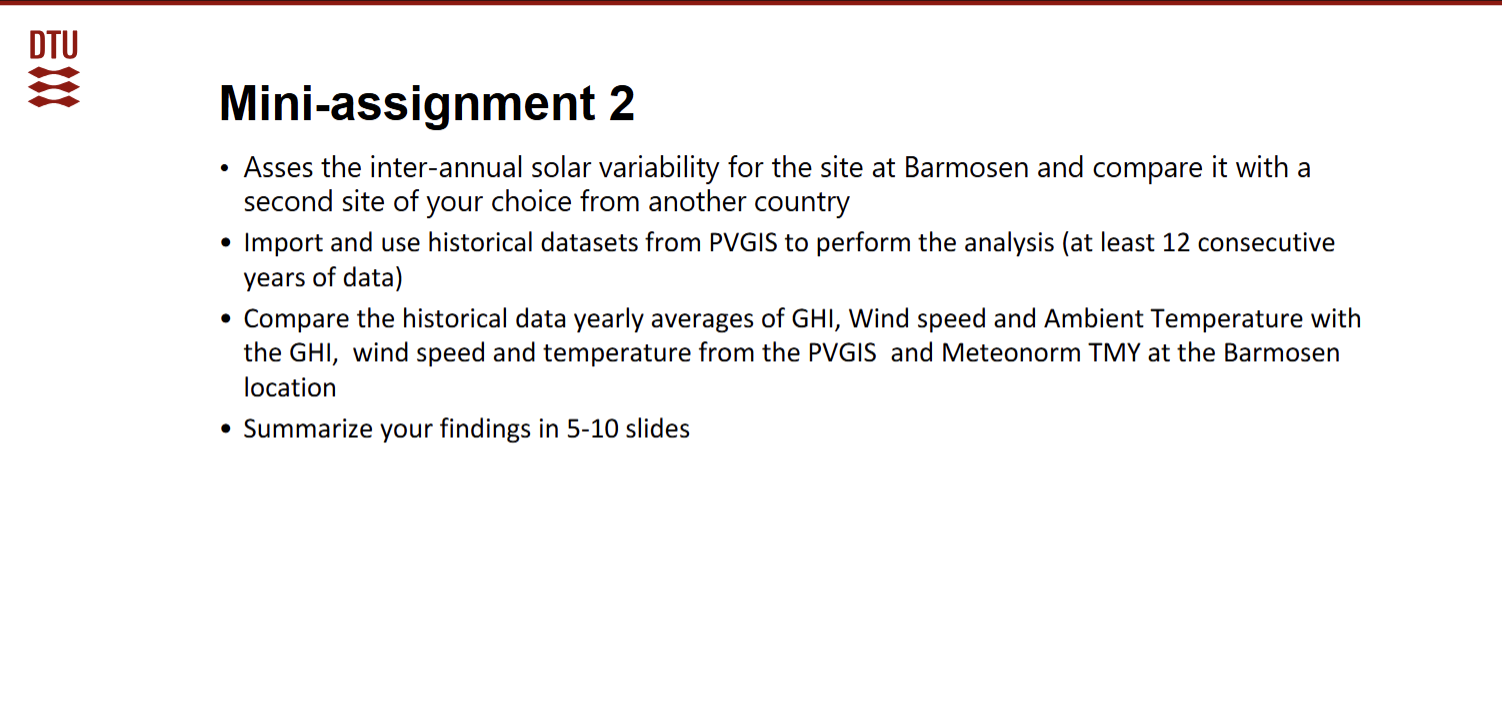

**First Location** 
Balmosen - France
Latitude : 43.7781
Longitude : 4.6395

**Second Location**
El Aromo - Ecuador
Latitude : -1.0710
Longitude : -80.7912

In [20]:
import os, re, pandas as pd, numpy as np, matplotlib.pyplot as plt

File paths 

In [ ]:
barm_PVGis_path= "Timeseries_Barmosen_2011_2023.csv"
aromo_PVGis_path = "Timeseries_El_Aromo_2011_2023.csv"

barm_Meteonorm_path = ""
aromo__Meteonorm_path= ""

**PVGIS CSV READER** 

In case it is not well define the structure

In [22]:
def read_pvgis_timeseries(path: str) -> pd.DataFrame:
    # find header and separator
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    sep = ';' if ';' in lines[0] or any(';' in ln for ln in lines[:50]) else ','
    header_idx = None
    for i, ln in enumerate(lines[:200]):
        parts = [p.strip() for p in ln.strip().split(sep)]
        if any(p.lower() == 'time' for p in parts):
            header_idx = i; break
    if header_idx is None:
        for i, ln in enumerate(lines[:200]):
            if re.match(r'^\s*time\s*[,;]', ln, flags=re.I):
                header_idx = i; break
    if header_idx is None:
        raise ValueError("Could not detect header row with 'time'")
    df = pd.read_csv(path, sep=sep, skiprows=header_idx, engine='python')
    df.columns = [re.sub(r'\s*\(.*?\)', '', c).strip() for c in df.columns]
    tcol = 'time' if 'time' in df.columns else [c for c in df.columns if c.lower()=='time'][0]
    # try iso parse, else fallback to PVGIS custom format YYYYMMDD:HHMM
    t = pd.to_datetime(df[tcol], utc=True, errors='coerce')
    if t.isna().mean() > 0.5:
        t = pd.to_datetime(df[tcol], format='%Y%m%d:%H%M', utc=True, errors='coerce')
    df[tcol] = t
    df = df.dropna(subset=[tcol]).set_index(tcol).sort_index()
    return df

**DEFINING METRICS** 

In [23]:
def yearly_metrics_numeric(df, cols):
    d = df.copy()
    for c in [cols["ghi"], cols["temp"], cols["wind"]]:
        if c:
            d[c] = pd.to_numeric(d[c], errors='coerce')
    d["GHI_kWhm2"] = d[cols["ghi"]] / 1000.0
    annual = pd.DataFrame({"GHI_kWhm2_yr": d["GHI_kWhm2"].resample("Y").sum()})
    if cols["temp"] in d.columns:
        annual["Temp_C_mean"] = d[cols["temp"]].resample("Y").mean()
    if cols["wind"] in d.columns:
        annual["Wind_ms_mean"] = d[cols["wind"]].resample("Y").mean()
    annual.index = annual.index.year
    return annual

def variability(annual):
    out = {}
    for col in annual.columns:
        s = annual[col].dropna()
        mu = s.mean(); sd = s.std(ddof=1)
        out[col] = {"mean": mu, "std": sd, "cov%": (sd/mu*100 if mu else np.nan)}
    return pd.DataFrame(out).round(2)

**LOAD INFO**

In [31]:
# Column mapping 
#PVGIS 
# 
barm_PVGis = read_pvgis_timeseries(barm_PVGis_path)
aromo_PVGis  = read_pvgis_timeseries(aromo_PVGis_path)

barm_PVGis_cols = {'ghi':'G','temp':'T2m','wind':'WS10m'}
aromo_PVGis_cols = {'ghi':'G','temp':'T2m','wind':'WS10m'}

barm_PVGis_ann = yearly_metrics_numeric(barm_PVGis, barm_PVGis_cols)
aromo_PVGis_ann = yearly_metrics_numeric(aromo_PVGis, aromo_PVGis_cols)

barm_PVGis_stats = variability(barm_PVGis_ann)
aromo_PVGis_stats = variability(aromo_PVGis_ann)


# Meteonorm

barm_Meteonorm = read_pvgis_timeseries(barm_Meteonorm_path)
aromo_Meteonorm  = read_pvgis_timeseries(aromo__Meteonorm_path)

barm_Meteonorm_cols = {'ghi':'GHI','temp':'T2m','wind':'WS10m'}
aromo_Meteonorm_cols = {'ghi':'GHI','temp':'T2m','wind':'WS10m'}

barm_Meteonorm_ann = yearly_metrics_numeric(barm_Meteonorm, barm_Meteonorm_cols)
aromo_Meteonorm_ann = yearly_metrics_numeric(aromo_Meteonorm, aromo_Meteonorm_cols)

barm_Meteonorm_stats = variability(barm_Meteonorm_ann)
aromo_Meteonorm_stats = variability(aromo_Meteonorm_ann)


C:\Users\Dmora\AppData\Local\Temp\ipykernel_59984\1645569392.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(df[tcol], utc=True, errors='coerce')
C:\Users\Dmora\AppData\Local\Temp\ipykernel_59984\1645569392.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(df[tcol], utc=True, errors='coerce')
C:\Users\Dmora\AppData\Local\Temp\ipykernel_59984\423010826.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual = pd.DataFrame({"GHI_kWhm2_yr": d["GHI_kWhm2"].resample("Y").sum()})
C:\Users\Dmora\AppData\Local\Temp\ipykernel_59984\423010826.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future versio

FileNotFoundError: [Errno 2] No such file or directory: ''

In [25]:
print("Barmosen Annual Metrics")
print(barm_PVGis_ann)

print("\nBarmosen Variability")
print(barm_PVGis_stats)

print("\nEl Aromo Annual Metrics")
print(aromo_PVGis_ann)
print("\nEl Aromo Variability")
print(aromo_PVGis_stats)

Barmosen Annual Metrics
      GHI_kWhm2_yr  Temp_C_mean  Wind_ms_mean
time                                         
2011    1650.89429    15.722229      3.388412
2012    1666.15006    15.343580      3.783562
2013    1593.87319    14.657599      3.768752
2014    1607.42235    16.079243      3.553589
2015    1677.25175    15.783288      3.500998
2016    1604.31704    15.636298      3.572519
2017    1675.83548    16.005857      3.710244
2018    1596.79558    16.342984      3.386844
2019    1669.87971    16.245213      3.578651
2020    1628.82429    16.100510      3.234160
2021    1616.05948    15.370686      3.440846
2022    1662.79025    16.885659      3.364282
2023    1661.57322    16.512692      3.385226

Barmosen Variability
      GHI_kWhm2_yr  Temp_C_mean  Wind_ms_mean
mean       1639.36        15.90          3.51
std          32.11         0.58          0.17
cov%          1.96         3.63          4.79

El Aromo Annual Metrics
      GHI_kWhm2_yr  Temp_C_mean  Wind_ms_mean
time     

**PLOTTING**

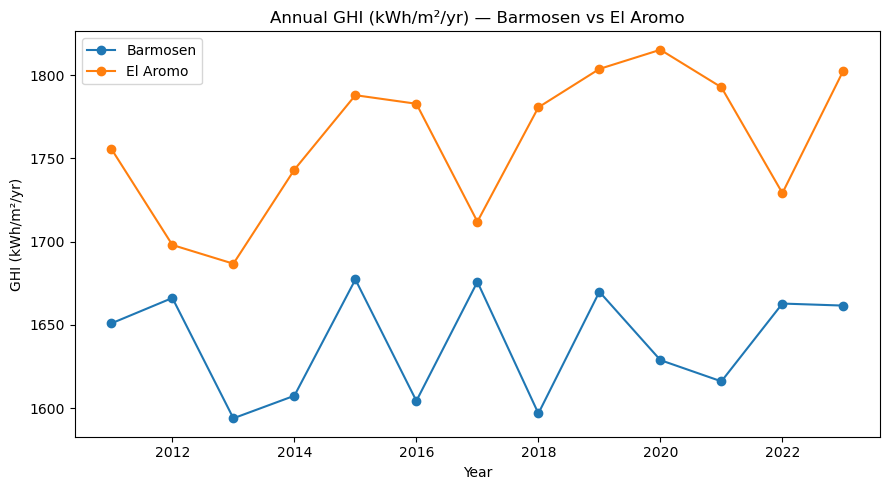

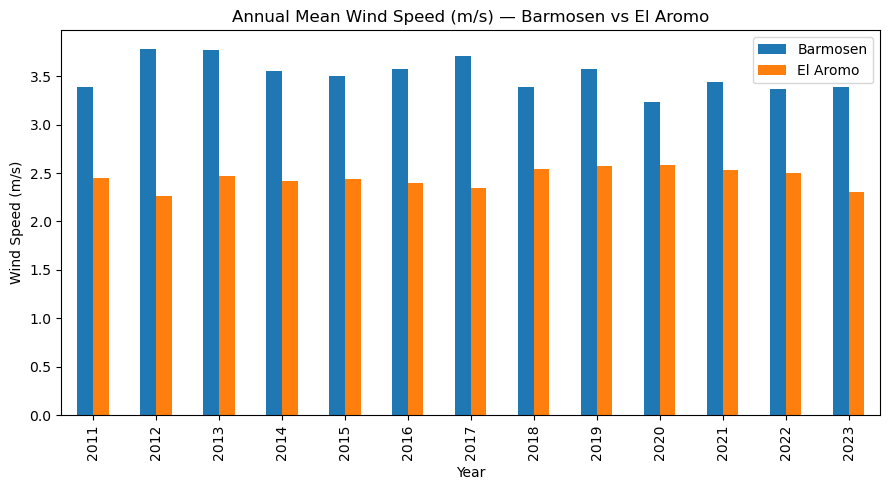

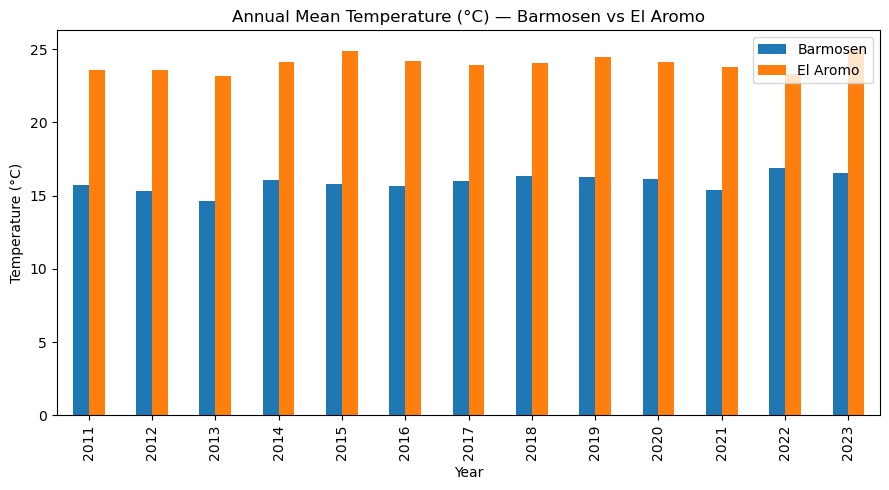

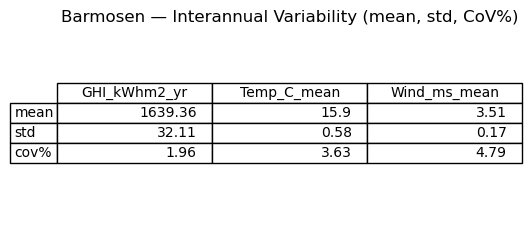

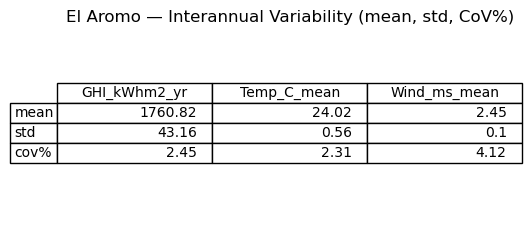

In [26]:
# 1) Annual GHI
plt.figure(figsize=(9,5))
plt.plot(barm_PVGis_ann.index, barm_PVGis_ann["GHI_kWhm2_yr"], marker="o", label="Barmosen")
plt.plot(aromo_PVGis_ann.index, aromo_PVGis_ann["GHI_kWhm2_yr"], marker="o", label="El Aromo")
plt.title("Annual GHI (kWh/m²/yr) — Barmosen vs El Aromo")
plt.xlabel("Year"); plt.ylabel("GHI (kWh/m²/yr)")
plt.legend(); plt.tight_layout()
plt.show()

# 2) Wind speed
plt.figure(figsize=(9,5))
wind_bar = pd.DataFrame({"Barmosen": barm_PVGis_ann["Wind_ms_mean"], "El Aromo": aromo_PVGis_ann["Wind_ms_mean"]})
wind_bar.plot(kind="bar", ax=plt.gca())
plt.title("Annual Mean Wind Speed (m/s) — Barmosen vs El Aromo")
plt.xlabel("Year"); plt.ylabel("Wind Speed (m/s)")
plt.tight_layout()
plt.show()

# 3) Temperature
plt.figure(figsize=(9,5))
temp_bar = pd.DataFrame({"Barmosen": barm_PVGis_ann["Temp_C_mean"], "El Aromo": aromo_PVGis_ann["Temp_C_mean"]})
temp_bar.plot(kind="bar", ax=plt.gca())
plt.title("Annual Mean Temperature (°C) — Barmosen vs El Aromo")
plt.xlabel("Year"); plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.show()

# 4) Variability tables
for name, stats in [("Barmosen", barm_PVGis_stats), ("El Aromo", aromo_PVGis_stats)]:
    fig, ax = plt.subplots(figsize=(6,2.4))
    ax.axis("off")
    tbl = ax.table(cellText=stats.values,
                   colLabels=stats.columns,
                   rowLabels=stats.index,
                   loc="center")
    tbl.scale(1,1.2)
    plt.title(f"{name} — Interannual Variability (mean, std, CoV%)")
    plt.show()




-- -- -- -- -- 

**COMPARING DAILY DATA**

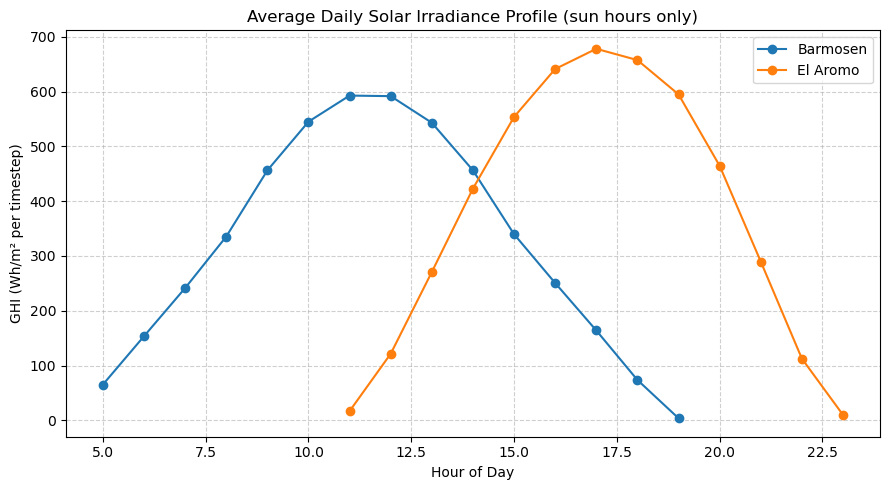

In [ ]:
# Hourly profile analysis (sun visible only)

def daily_hourly_profile(df, ghi_col):
    d = df.copy()
    d[ghi_col] = pd.to_numeric(d[ghi_col], errors='coerce')
    d = d[d[ghi_col] > 0]   # keep only when sun is visible
    d["hour"] = d.index.hour
    profile = d.groupby("hour")[ghi_col].mean()
    return profile

# Compute profiles
b_profile = daily_hourly_profile(barm_PVGis, "G")
a_profile = daily_hourly_profile(aromo_PVGis, "G")

# Plot
plt.figure(figsize=(9,5))
plt.plot(b_profile.index, b_profile.values, marker="o", label="Barmosen")
plt.plot(a_profile.index, a_profile.values, marker="o", label="El Aromo")
plt.title("Average Daily Solar Irradiance Profile (sun hours only)")
plt.xlabel("Hour of Day"); plt.ylabel("GHI (Wh/m² per timestep)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


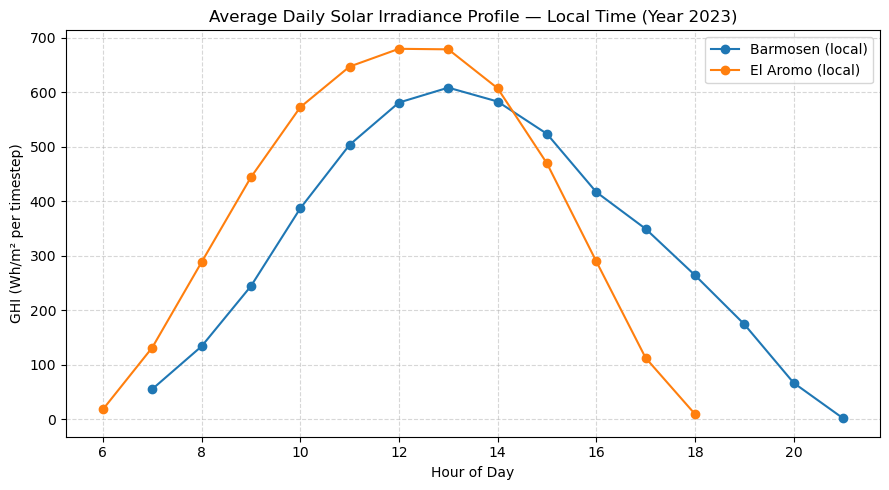

'/mnt/data/daily_profile_2023_local.png'

In [ ]:

from zoneinfo import ZoneInfo


# Columns (based on your files: G(i), T2m, WS10m -> normalized names: 'G', 'T2m', 'WS10m')
ghi_col = "G"

# Convert to local time and filter year 2023 (local year)
barm_local = barm_PVGis.tz_convert(ZoneInfo("Europe/Copenhagen"))
aro_local  = aromo_PVGis.tz_convert(ZoneInfo("America/Guayaquil"))

barm_2023 = barm_local[(barm_local.index.year == 2023)].copy()
aro_2023  = aro_local[(aro_local.index.year == 2023)].copy()

# Build hourly profiles for sun-visible only
for df in (barm_2023, aro_2023):
    df[ghi_col] = pd.to_numeric(df[ghi_col], errors="coerce")

barm_day = barm_2023[barm_2023[ghi_col] > 0].copy()
aro_day  = aro_2023[aro_2023[ghi_col]  > 0].copy()

barm_day["hour"] = barm_day.index.hour
aro_day["hour"]  = aro_day.index.hour

b_profile = barm_day.groupby("hour")[ghi_col].mean()
a_profile = aro_day.groupby("hour")[ghi_col].mean()

# Plot
plt.figure(figsize=(9,5))
plt.plot(b_profile.index, b_profile.values, marker="o", label="Barmosen (local)")
plt.plot(a_profile.index, a_profile.values, marker="o", label="El Aromo (local)")
plt.title("Average Daily Solar Irradiance Profile — Local Time (Year 2023)")
plt.xlabel("Hour of Day"); plt.ylabel("GHI (Wh/m² per timestep)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
out_path = "/mnt/data/daily_profile_2023_local.png"
plt.show()

out_path


In [ ]:

# --- Filter September 1, 2023 ---
date = "2022-12-12"
barm_day = barm_PVGis.loc[date]
aro_day  = aromo_PVGis.loc[date]

# --- Select columns of interest ---
cols = ["G", "T2m", "WS10m"]
barm_day = barm_day[cols]
aro_day  = aro_day[cols]

print("Barmosen — September 1, 2023")
print(barm_day.head(24))   # hourly view

print("\nEl Aromo — September 1, 2023")
print(aro_day.head(24))

Barmosen — September 1, 2023
                                G   T2m  WS10m
time                                          
2022-12-12 00:10:00+00:00     0.0 -0.13   2.97
2022-12-12 01:10:00+00:00     0.0 -0.26   2.69
2022-12-12 02:10:00+00:00     0.0 -0.48   2.48
2022-12-12 03:10:00+00:00     0.0 -0.57   2.21
2022-12-12 04:10:00+00:00     0.0 -0.86   2.07
2022-12-12 05:10:00+00:00     0.0 -1.21   2.14
2022-12-12 06:10:00+00:00     0.0 -1.45   2.14
2022-12-12 07:10:00+00:00     0.0 -1.78   2.28
2022-12-12 08:10:00+00:00  102.01 -1.44   2.14
2022-12-12 09:10:00+00:00  221.01  0.77   1.79
2022-12-12 10:10:00+00:00  338.01  3.19   1.86
2022-12-12 11:10:00+00:00  394.01  4.81   1.79
2022-12-12 12:10:00+00:00   267.0  5.99   1.45
2022-12-12 13:10:00+00:00   238.0  6.33   1.10
2022-12-12 14:10:00+00:00    95.0  6.07   1.10
2022-12-12 15:10:00+00:00    30.0  5.04   1.79
2022-12-12 16:10:00+00:00     0.0  3.96   2.21
2022-12-12 17:10:00+00:00     0.0  3.30   2.21
2022-12-12 18:10:00+00:00     0

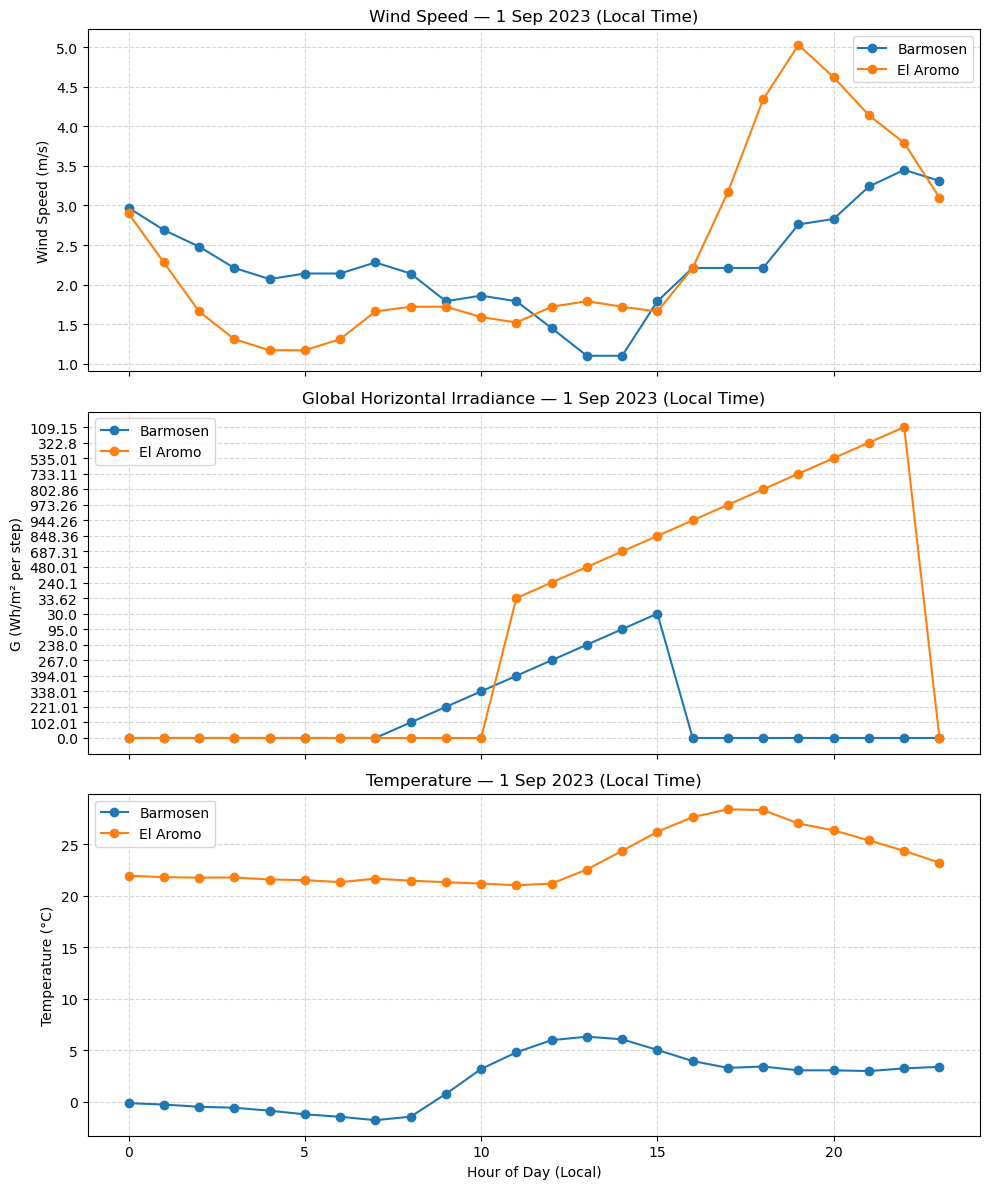

'/mnt/data/comparison_2023-09-01_localtime.png'

In [ ]:

# --- Plot comparisons ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Wind
axes[0].plot(barm_day.index.hour, barm_day["WS10m"], marker="o", label="Barmosen")
axes[0].plot(aro_day.index.hour, aro_day["WS10m"], marker="o", label="El Aromo")
axes[0].set_ylabel("Wind Speed (m/s)")
axes[0].set_title("Wind Speed — 1 Sep 2023 (Local Time)")
axes[0].legend(); axes[0].grid(True, linestyle="--", alpha=0.5)

# GHI
axes[1].plot(barm_day.index.hour, barm_day["G"], marker="o", label="Barmosen")
axes[1].plot(aro_day.index.hour, aro_day["G"], marker="o", label="El Aromo")
axes[1].set_ylabel("G (Wh/m² per step)")
axes[1].set_title("Global Horizontal Irradiance — 1 Sep 2023 (Local Time)")
axes[1].legend(); axes[1].grid(True, linestyle="--", alpha=0.5)

# Temperature
axes[2].plot(barm_day.index.hour, barm_day["T2m"], marker="o", label="Barmosen")
axes[2].plot(aro_day.index.hour, aro_day["T2m"], marker="o", label="El Aromo")
axes[2].set_ylabel("Temperature (°C)")
axes[2].set_xlabel("Hour of Day (Local)")
axes[2].set_title("Temperature — 1 Sep 2023 (Local Time)")
axes[2].legend(); axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
out_path = "/mnt/data/comparison_2023-09-01_localtime.png"
plt.show()

out_path

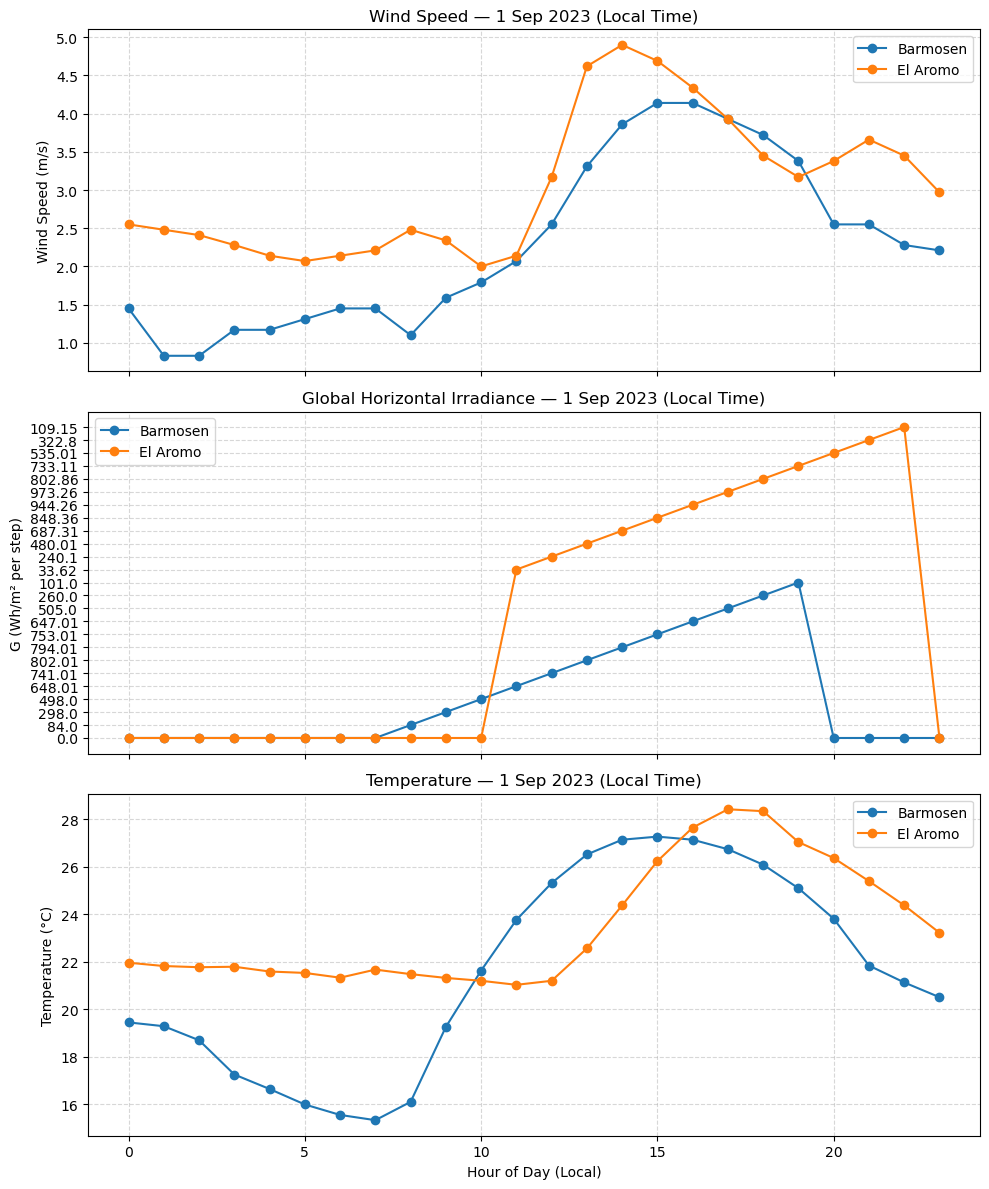

In [ ]:
from zoneinfo import ZoneInfo

# Convertir a hora local
barm_local = barm_PVGis.tz_convert(ZoneInfo("Europe/Copenhagen"))
aromo_local = aromo_PVGis.tz_convert(ZoneInfo("America/Guayaquil"))

# Filtrar el 1 de septiembre 2023 (hora local)
date = "2023-09-01"
cols = ["G", "T2m", "WS10m"]

barm_day = barm_local.loc[date, cols].copy()
aromo_day = aromo_local.loc[date, cols].copy()

# --- Plots ---
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Wind
axes[0].plot(barm_day.index.hour, barm_day["WS10m"], marker="o", label="Barmosen")
axes[0].plot(aromo_day.index.hour, aromo_day["WS10m"], marker="o", label="El Aromo")
axes[0].set_ylabel("Wind Speed (m/s)")
axes[0].set_title("Wind Speed — 1 Sep 2023 (Local Time)")
axes[0].legend(); axes[0].grid(True, linestyle="--", alpha=0.5)

# GHI
axes[1].plot(barm_day.index.hour, barm_day["G"], marker="o", label="Barmosen")
axes[1].plot(aromo_day.index.hour, aro_day["G"], marker="o", label="El Aromo")
axes[1].set_ylabel("G (Wh/m² per step)")
axes[1].set_title("Global Horizontal Irradiance — 1 Sep 2023 (Local Time)")
axes[1].legend(); axes[1].grid(True, linestyle="--", alpha=0.5)

# Temperature
axes[2].plot(barm_day.index.hour, barm_day["T2m"], marker="o", label="Barmosen")
axes[2].plot(aromo_day.index.hour, aro_day["T2m"], marker="o", label="El Aromo")
axes[2].set_ylabel("Temperature (°C)")
axes[2].set_xlabel("Hour of Day (Local)")
axes[2].set_title("Temperature — 1 Sep 2023 (Local Time)")
axes[2].legend(); axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


Column 'G' not found in one of the DataFrames.


C:\Users\Dmora\AppData\Local\Temp\ipykernel_59984\4037549426.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)


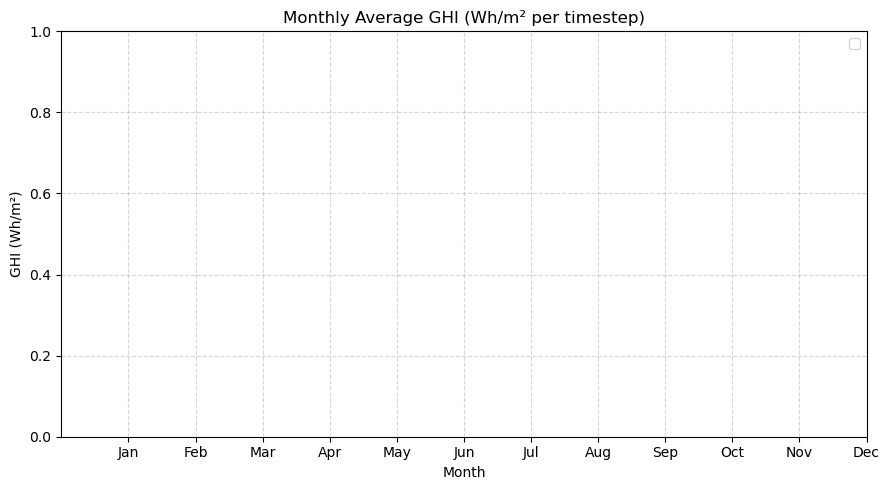

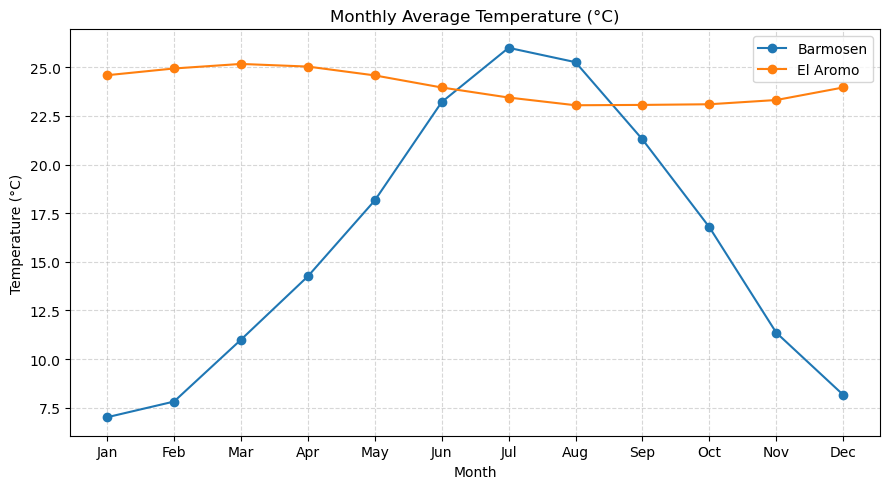

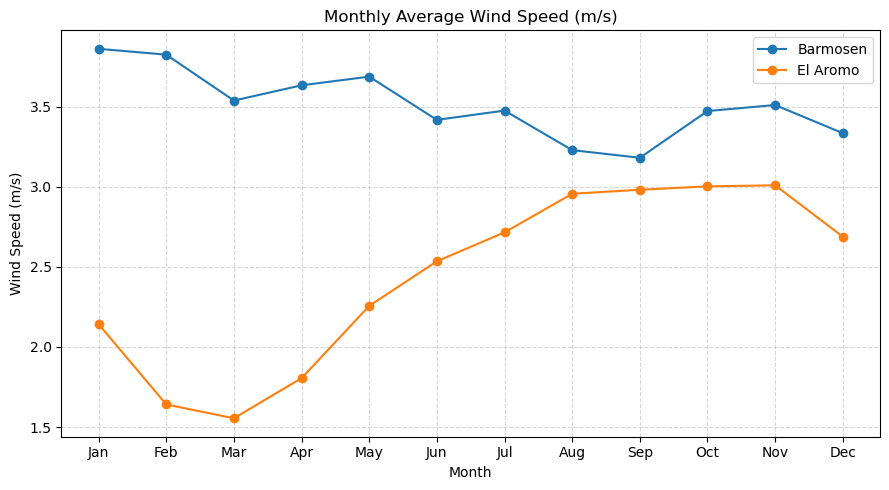

In [ ]:

# --- Monthly averages ---
def monthly_means(df):
    dfm = df.copy()
    dfm["month"] = dfm.index.month
    return dfm.groupby("month").mean(numeric_only=True)

barm_monthly = monthly_means(barm_PVGis)
aro_monthly  = monthly_means(aromo_PVGis)

months = range(1,13)
month_labels = [pd.to_datetime(str(m), format="%m").strftime("%b") for m in months]

# --- Plot GHI ---
plt.figure(figsize=(9,5))
if "G" in barm_monthly.columns and "G" in aro_monthly.columns:
    plt.plot(months, barm_monthly["G"], marker="o", label="Barmosen")
    plt.plot(months, aro_monthly["G"], marker="o", label="El Aromo")
else:
    print("Column 'G' not found in one of the DataFrames.")
plt.xticks(months, month_labels)
plt.title("Monthly Average GHI (Wh/m² per timestep)")
plt.xlabel("Month"); plt.ylabel("GHI (Wh/m²)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot Temperature ---
plt.figure(figsize=(9,5))
plt.plot(months, barm_monthly["T2m"], marker="o", label="Barmosen")
plt.plot(months, aro_monthly["T2m"], marker="o", label="El Aromo")
plt.xticks(months, month_labels)
plt.title("Monthly Average Temperature (°C)")
plt.xlabel("Month"); plt.ylabel("Temperature (°C)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot Wind ---
plt.figure(figsize=(9,5))
plt.plot(months, barm_monthly["WS10m"], marker="o", label="Barmosen")
plt.plot(months, aro_monthly["WS10m"], marker="o", label="El Aromo")
plt.xticks(months, month_labels)
plt.title("Monthly Average Wind Speed (m/s)")
plt.xlabel("Month"); plt.ylabel("Wind Speed (m/s)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
